
# Formations

You can plot formations (e.g. 4-4-2) on any mplsoccer pitch using the ``formation`` method.
The formations work is a collaboration between
[Dmitry Mogilevsky](https://twitter.com/ChicagoDmitry) and
[Andy Rowlinson](https://twitter.com/numberstorm).

The formations can be plotted as various options by using the ``kind`` argument:

* ``kind='scatter'``

* ``kind='image'``

* ``kind='axes'``

* ``kind='pitch'``

* ``kind='text'``


In [1]:
!pip install mplsoccer statsbombpy
from mplsoccer import VerticalPitch, Pitch, FontManager, Sbopen
import statsbombpy
from statsbombpy import sb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.2 MB/s eta 0:00:00


In [2]:
import math
from urllib.request import urlopen

import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from mplsoccer import VerticalPitch, Sbopen, FontManager, inset_image

# data parser, fonts and path effects for giving the font an edge
parser = Sbopen()
roboto_bold = FontManager(
    'https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/RobotoSlab%5Bwght%5D.ttf')
path_eff = [path_effects.Stroke(linewidth=3, foreground='white'),
            path_effects.Normal()]

## Get Wyscout data
The next example uses some example
[Wyscout data](https://www.hudl.com/blog/wyscout-analysis-chelsea-vs-manchester-united).



In [9]:
parser = Sbopen()
events, related, freeze, players = parser.event(3943043)
TEAM = 'Spain'
OPPONENT = 'versus England, 2024 EURO FINAL'


In [10]:
events.loc[events.tactics_formation.notnull(), 'tactics_id'] = events.loc[
    events.tactics_formation.notnull(), 'id']
events[['tactics_id', 'tactics_formation']] = events.groupby('team_name')[[
    'tactics_id', 'tactics_formation']].ffill()

In [11]:

formation_dict = {1: 'GK', 2: 'RB', 3: 'RCB', 4: 'CB', 5: 'LCB', 6: 'LB', 7: 'RWB',
                  8: 'LWB', 9: 'RDM', 10: 'CDM', 11: 'LDM', 12: 'RM', 13: 'RCM',
                  14: 'CM', 15: 'LCM', 16: 'LM', 17: 'RW', 18: 'RAM', 19: 'CAM',
                  20: 'LAM', 21: 'LW', 22: 'RCF', 23: 'ST', 24: 'LCF', 25: 'SS'}
players['position_abbreviation'] = players.position_id.map(formation_dict)


In [12]:

sub = events.loc[events.type_name == 'Substitution',
                 ['tactics_id', 'player_id', 'substitution_replacement_id',
                  'substitution_replacement_name']]
players_sub = players.merge(sub.rename({'tactics_id': 'id'}, axis='columns'),
                            on=['id', 'player_id'], how='inner', validate='1:1')
players_sub = (players_sub[['id', 'substitution_replacement_id', 'position_abbreviation']]
               .rename({'substitution_replacement_id': 'player_id'}, axis='columns'))
players = pd.concat([players, players_sub])
players.rename({'id': 'tactics_id'}, axis='columns', inplace=True)
players = players[['tactics_id', 'player_id', 'position_abbreviation']]

In [13]:
# add on the position the player was playing in the formation to the events dataframe
events = events.merge(players, on=['tactics_id', 'player_id'], how='left', validate='m:1')
# add on the position the receipient was playing in the formation to the events dataframe
events = events.merge(players.rename({'player_id': 'pass_recipient_id'},
                                     axis='columns'), on=['tactics_id', 'pass_recipient_id'],
                      how='left', validate='m:1', suffixes=['', '_receipt'])

In [14]:
formation = events.groupby('team_name').tactics_formation.unique()
formation

,tactics_formation
team_name,
England,"[4231, 41212]"
Spain,[4231]


In [16]:
parser = Sbopen()
event, related, freeze, tactics = parser.event(3943043)
# starting players from Barcelona
starting_xi_event = event.loc[((event['type_name'] == 'Starting XI') &
                               (event['team_name'] == 'Spain')), ['id', 'tactics_formation']]
# joining on the team name and formation to the lineup
starting_xi = tactics.merge(starting_xi_event, on='id')
# replace player names with the shorter version
player_short_names= {
    'Mikel Merino Zazón': 'Mikel Merino',
    'José Luis Sanmartín Mato': 'Joselu',
    'Álvaro Borja Morata Martín': 'Álvaro Morata',
    'David Raya Martin': 'David Raya',
    'Aymeric Laporte': 'Laporte',
    'José Ignacio Fernández Iglesias': 'Nacho',
    'Daniel Carvajal Ramos': 'Dani Carvajal',
    'Fabián Ruiz Peña': 'Fabián Ruiz',
    'Mikel Oyarzabal Ugarte': 'Mikel Oyarzabal',
    'Ferrán Torres García': 'Ferrán Torres',
    'Rodrigo Hernández Cascante': 'Rodri',
    'Jesús Navas González': 'Jesús Navas',
    'Alejandro Grimaldo García': 'Álex Grimaldo',
    'Unai Simón Mendibil': 'Unai Simón',
    'Daniel Olmo Carvajal': 'Dani Olmo',
    'Marc Cucurella Saseta': 'Marc Cucurella',
    'Robin Aime Robert Le Normand': 'Robin Le Normand',
    'Martín Zubimendi Ibáñez': 'Martín Zubimendi',
    'Alejandro Remiro Gargallo': 'Álex Remiro',
    'Alejandro Baena Rodríguez': 'Álex Baena',
    'Daniel Vivian Moreno': 'Dani Vivian',
    'Nicholas Williams Arthuer': 'Nico Williams',
    'Fermin Lopez Marin': 'Fermín López',
    'Lamine Yamal Nasraoui Ebana': 'Lamine Yamal'
}
starting_xi['player_name'] = starting_xi['player_name'].replace(player_short_names)
# filter only succesful ball receipts from the starting XI
event = event.loc[((event['type_name'] == 'Ball Receipt') &
                   (event['outcome_name'].isnull()) &
                   (event['player_id'].isin(starting_xi['player_id']))
                   ), ['player_id', 'x', 'y']]
# merge on the starting positions to the events
event = event.merge(starting_xi, on='player_id')
formation = event['tactics_formation'].iloc[0]

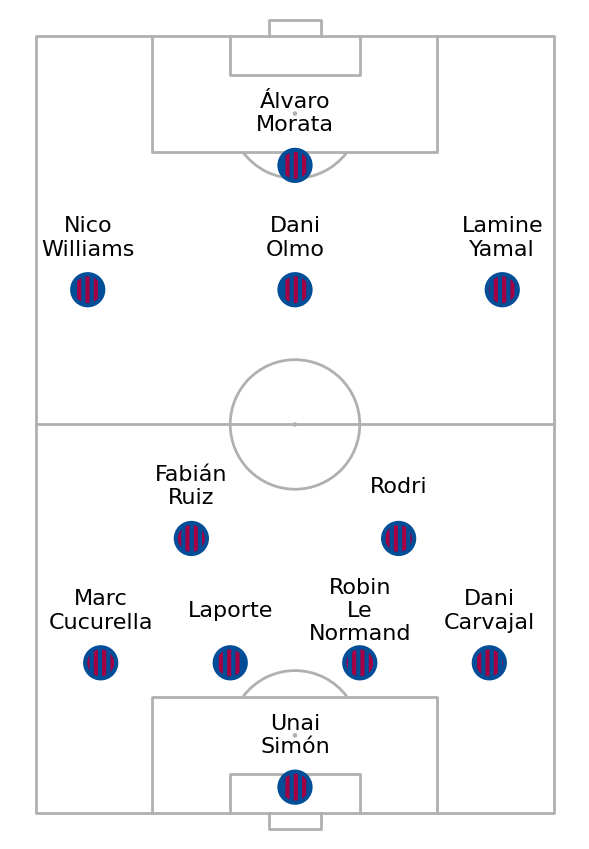

In [17]:
pitch = VerticalPitch(goal_type='box')
fig, ax = pitch.draw(figsize=(6, 8.72))
ax_text = pitch.formation(formation, positions=starting_xi.position_id, kind='text',
                          text=starting_xi.player_name.str.replace(' ', '\n'),
                          va='center', ha='center', fontsize=16, ax=ax)
# scatter markers
mpl.rcParams['hatch.linewidth'] = 3
mpl.rcParams['hatch.color'] = '#a50044'
ax_scatter = pitch.formation(formation, positions=starting_xi.position_id, kind='scatter',
                             c='#004d98', hatch='||', linewidth=3, s=500,
                             # you can also provide a single offset instead of a list
                             # for xoffset and yoffset
                             xoffset=-8,
                             ax=ax)

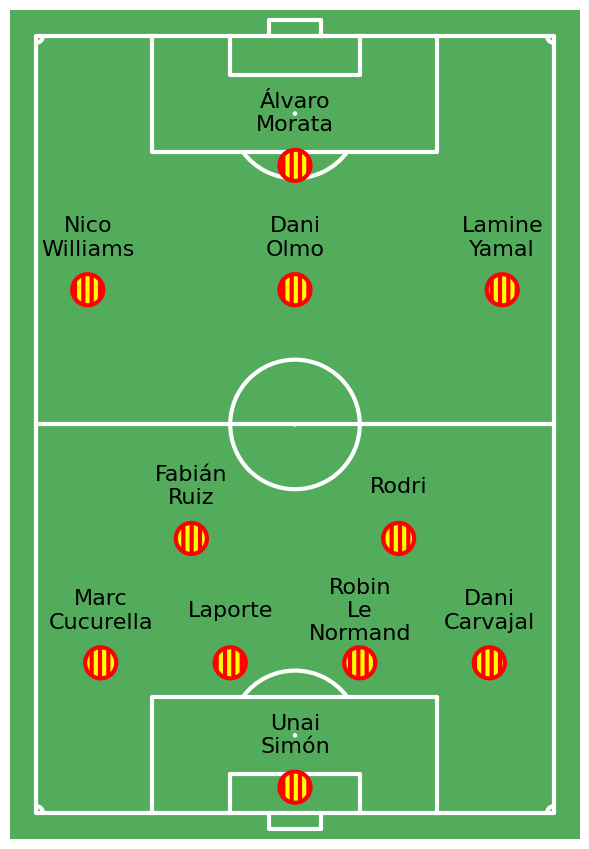

In [18]:
pitch = VerticalPitch(pitch_type='statsbomb', goal_type='box', pitch_color='#53ac5c',
                      line_color='white', linewidth=3, corner_arcs=True)
fig, ax = pitch.draw(figsize=(6, 8.72))
ax_text = pitch.formation(formation, positions=starting_xi.position_id, kind='text',
                          text=starting_xi.player_name.str.replace(' ', '\n'),
                          va='center', ha='center', fontsize=16, ax=ax)
# scatter markers
mpl.rcParams['hatch.linewidth'] = 3
mpl.rcParams['hatch.color'] = 'yellow'
ax_scatter = pitch.formation(formation, positions=starting_xi.position_id, kind='scatter',
                             c='red', hatch='||', linewidth=3, s=500,
                             # you can also provide a single offset instead of a list
                             # for xoffset and yoffset
                             xoffset=-8,
                             ax=ax)

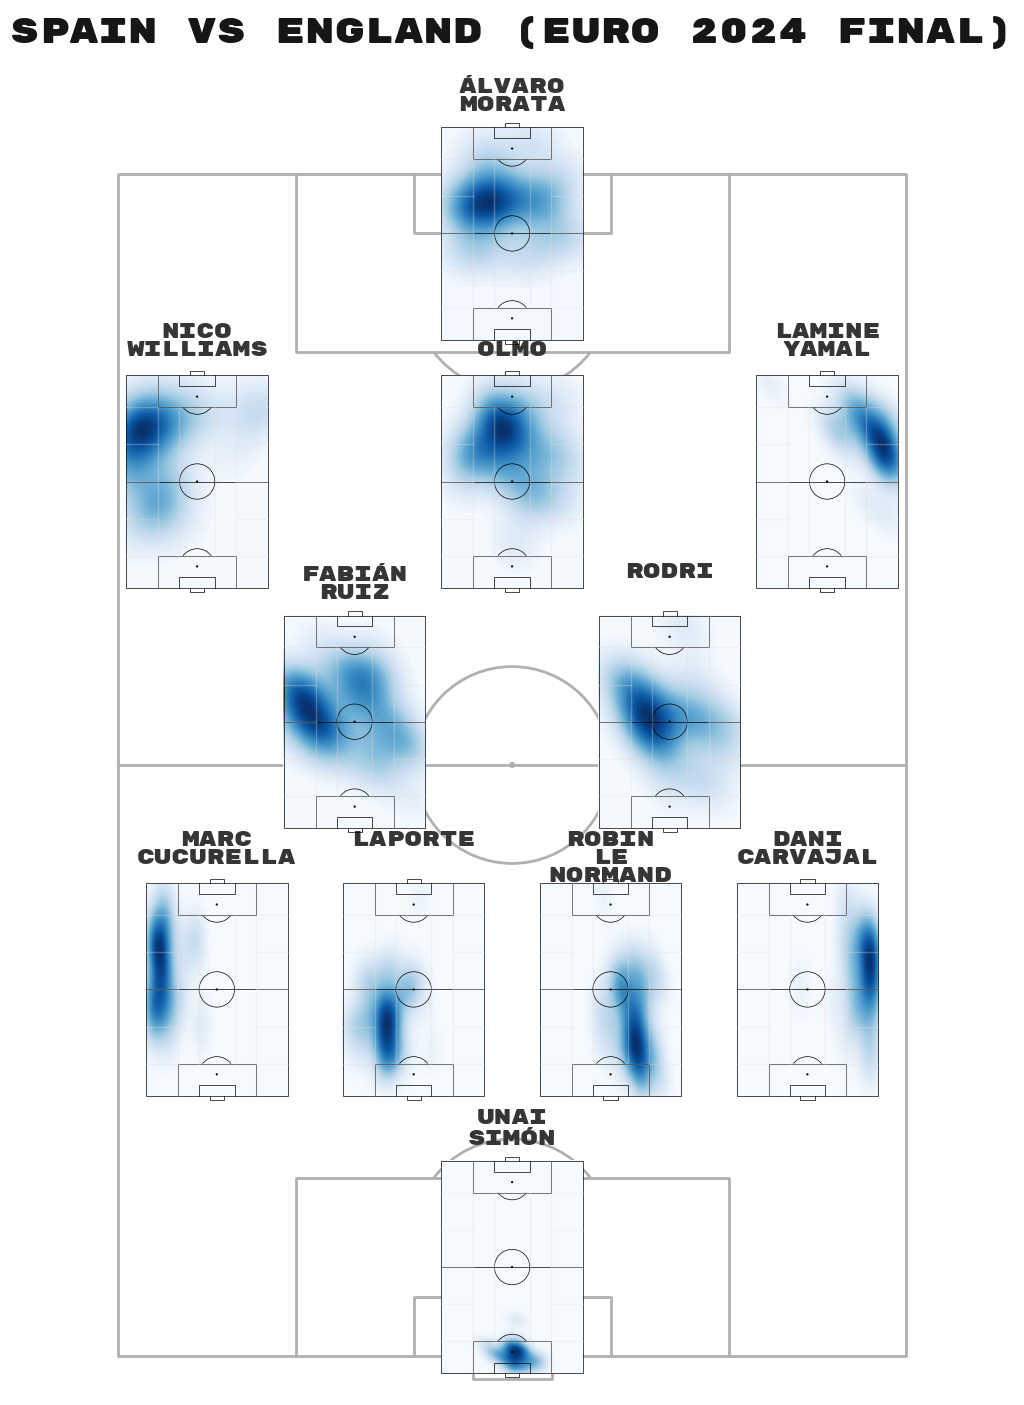

In [36]:
pitch = VerticalPitch(goal_type='box')
fig, axs = pitch.grid(endnote_height=0, title_height=0.08, figheight=14, grid_width=0.9,
                      grid_height=0.9, axis=False)
fm_rubik = FontManager('https://raw.githubusercontent.com/google/fonts/main/ofl/'
                       'rubikmonoone/RubikMonoOne-Regular.ttf')
title = axs['title'].text(0.5, 0.8, 'Spain vs England (euro 2024 final)', fontsize=25,
                          va='center',
                          ha='center', color='#161616', fontproperties=fm_rubik.prop)

pitch_ax = pitch.formation(formation,
                           kind='pitch',
                           # avoid overlapping pitches with offsets
                          #  xoffset=[-3, 6, 6, 6, 6, 14, 0, 0, 0, 0, 0],
                           xoffset=[-3, 6, 6, 6, 6, 14, 14, 0, 0, 0, 6],

                           # pitch is 23 units long (could also set the height).
                           # note this is set assuming the pitch is horizontal, but in this example
                           # it is vertical so that you get the same results
                           # from both VerticalPitch and Pitch
                           width=23,
                           positions=starting_xi['position_id'],
                           ax=axs['pitch'],
                           # additional arguments temporarily amend the pitch appearance
                           # note we are plotting a really faint positional grid
                           # that overlays the kdeplot
                           linewidth=0.5,
                           pitch_color='None',
                           line_zorder=3,
                           line_color='black',
                           positional=True,
                           positional_zorder=3,
                           positional_linewidth=1,
                           positional_alpha=0.3,
                           )

# adding kdeplot and player titles
for position in pitch_ax:
    player_name = starting_xi[starting_xi['position_id'] == position].player_name.iloc[0]
    player_name = player_name.replace(' ', '\n').replace('-', '-\n')
    pitch.text(150, 40, player_name, va='top', ha='center', fontsize=15, ax=pitch_ax[position],
               fontproperties=fm_rubik.prop, color='#353535')
    pitch.kdeplot(x=event.loc[event['position_id'] == position, 'x'],
                  y=event.loc[event['position_id'] == position, 'y'],
                  fill=True, levels=100, cut=100, cmap='Blues', thresh=0, ax=pitch_ax[position])